In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
from scipy.interpolate import UnivariateSpline
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, ICRS
from astropy.time import Time
import astropy.units as u

In [2]:
df = pd.read_csv('../ID003.csv')

In [3]:
df['UTC_DATE'] = pd.to_datetime(df['UTC_DATE'], errors='coerce')
df['LOCTIME']= pd.to_datetime(df['LOCTIME'], errors='coerce')
df['LOC_DATE'] = df['UTC_DATE'] + pd.Timedelta(hours=4)
df = df.set_index('LOC_DATE') #Mettre l'index a l'heure de la Reunion

df['ra_zenith_h'] = df['ALPHAZEN'] / 15.0 #Conversion de RA en heure

In [4]:
df['dt'] = (df['T_AMB'] - df['T_SKY']).copy()

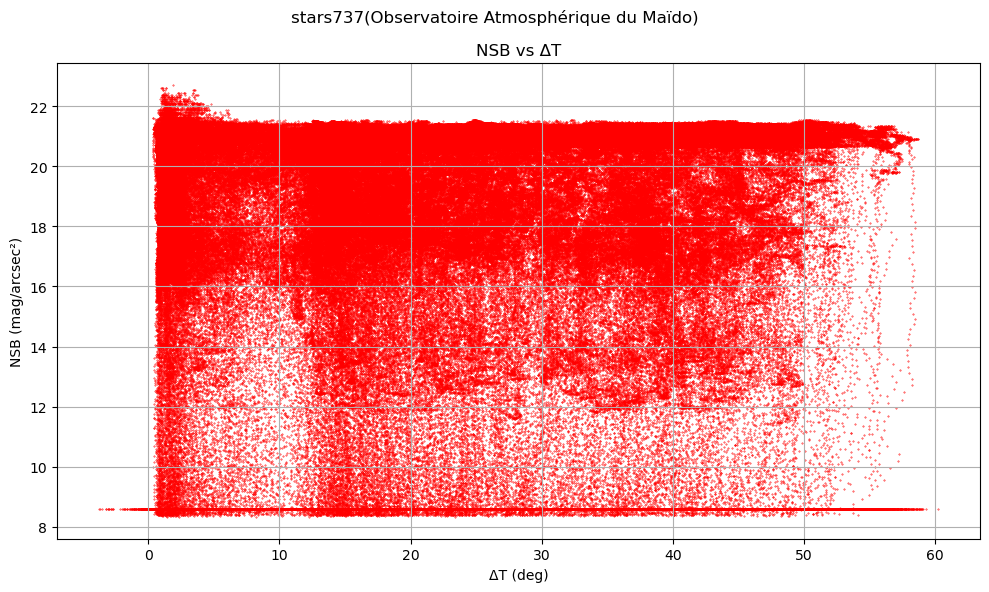

In [5]:
#Distribution de la brillance du ciel sur les 3 ans par rapport à ΔT avant filtrage

plt.figure(figsize=(10, 6))

plt.scatter(df['dt'], df['NSB'], marker='.', s=0.5, color ='red')

plt.suptitle('stars737(Observatoire Atmosphérique du Maïdo)')
plt.title(u'NSB vs ΔT')
plt.xlabel(u'ΔT (deg)')
plt.ylabel("NSB (mag/arcsec²)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
#Definition d'un ciel nocturne, sans lune et claire

seuil_soleil = -18
seuil_illumination = 0.05  # Pourcentage d'illumination max (5%)
seuil_altitude_lune = -10  # Altitude max de la lune (0 pour sous l'horizon)
seuil_dt = 20 # ΔT superieure à 20°

night = df[
    (df['ALT_SUN'] < seuil_soleil) &
#    (df['ILLUMOON'] < seuil_illumination) &
    (df['ALT_MOON'] < seuil_altitude_lune) &
    (df['dt'] > seuil_dt)
].copy()

night.index = pd.to_datetime(night.index)

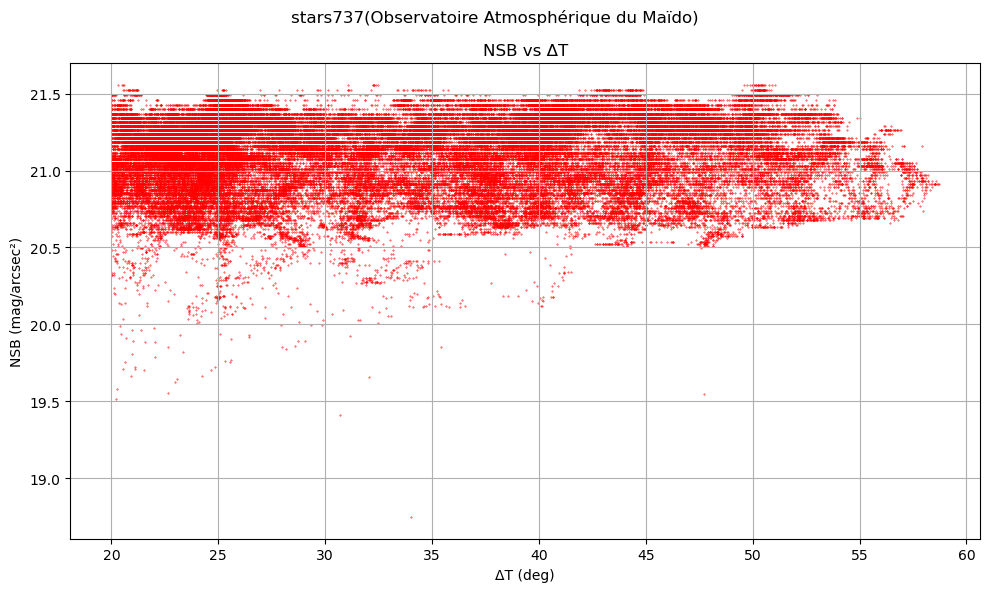

In [7]:
#Distribution de la brillance du ciel sur les 3 ans par rapport à ΔT apres le filtre

plt.figure(figsize=(10, 6))

plt.scatter(night['dt'], night['NSB'], marker='.', s=0.5, color ='red')

plt.suptitle('stars737(Observatoire Atmosphérique du Maïdo)')
plt.title(u'NSB vs ΔT')
plt.xlabel(u'ΔT (deg)')
plt.ylabel("NSB (mag/arcsec²)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
#Creation d'un sous dataframe
necessary_columns = ['UTC_DATE','UTC_JD','UTC_DATE', 'UTC_JD', 'UTCTIME', 'LOC_JD','LOCTIME', 'T_AMB',
                    'T_SKY', 'FREQ', 'NSB', 'AZ_SUN', 'ALT_SUN', 'AZ_MOON','ALT_MOON', 'AGE_MOON', 'ILLUMOON', 'DISTMOON', 'L_ZEN', 'B_ZEN',
                     'ra_zenith_h', 'BETAZEN','dt']

night_r = night[necessary_columns]

In [9]:
#Moyenner les données brutes de 1 minute sur des intervalles de 5 minutes échantillons de 5 minutes. (Grauer A. & Grauer P., 2021)

night_5  = night_r .resample('5min').mean()

In [10]:
night_5

,UTC_DATE,UTC_JD,UTC_DATE,UTC_JD,UTCTIME,LOC_JD,LOCTIME,T_AMB,T_SKY,FREQ,...,AZ_MOON,ALT_MOON,AGE_MOON,ILLUMOON,DISTMOON,L_ZEN,B_ZEN,ra_zenith_h,BETAZEN,dt
LOC_DATE,,,,,,,,,,,,,,,,,,,,,
2022-05-24 19:00:00,2022-05-24 15:03:56.500,2.459724e+06,2022-05-24 15:03:56.500,2.459724e+06,-8.934306,2.459724e+06,1969-12-31 23:59:59.999999996,10.020,-27.030,0.595,...,210.470475,-59.719185,24.015479,0.306510,385050.080,269.145705,34.039333,11.557640,-25.783952,37.050
2022-05-24 19:05:00,2022-05-24 15:07:27.600,2.459724e+06,2022-05-24 15:07:27.600,2.459724e+06,-8.875667,2.459724e+06,1969-12-31 23:59:59.999999996,10.016,-27.624,0.554,...,208.980730,-60.125237,24.017909,0.306272,385060.986,269.994092,34.470395,11.612725,-25.434969,37.640
2022-05-24 19:10:00,2022-05-24 15:12:29.600,2.459724e+06,2022-05-24 15:12:29.600,2.459724e+06,-8.791778,2.459724e+06,1969-12-31 23:59:59.999999996,10.046,-27.928,0.518,...,206.788054,-60.676183,24.021385,0.305931,385076.598,271.226768,35.070910,11.691241,-24.934950,37.974
2022-05-24 19:15:00,2022-05-24 15:17:31.800,2.459724e+06,2022-05-24 15:17:31.800,2.459724e+06,-8.707833,2.459724e+06,1969-12-31 23:59:59.999999996,10.016,-28.192,0.508,...,204.517964,-61.188177,24.024862,0.305590,385092.212,272.484004,35.651017,11.769465,-24.433823,38.208
2022-05-24 19:20:00,2022-05-24 15:21:03.500,2.459724e+06,2022-05-24 15:21:03.500,2.459724e+06,-8.649028,2.459724e+06,1969-12-31 23:59:59.999999996,9.910,-27.830,0.505,...,202.886000,-61.523788,24.027298,0.305351,385103.175,273.378005,36.045413,11.824077,-24.082435,37.740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 23:05:00,2025-06-18 19:07:04.800,2.460845e+06,2025-06-18 19:07:04.800,2.460845e+06,-4.882000,2.460845e+06,1970-01-01 00:00:00.000000000,10.084,-10.448,0.630,...,97.235717,-16.830560,22.126586,0.502272,373387.782,357.283686,17.380068,16.699669,1.005030,20.532
2025-06-18 23:10:00,2025-06-18 19:12:05.000,2.460845e+06,2025-06-18 19:12:05.000,2.460845e+06,-4.798611,2.460845e+06,1970-01-01 00:00:00.000000000,10.080,-10.566,0.540,...,96.737592,-15.717731,22.130259,0.501881,373374.724,358.049078,16.467147,16.776980,1.163868,20.646
2025-06-18 23:15:00,2025-06-18 19:17:05.000,2.460845e+06,2025-06-18 19:17:05.000,2.460845e+06,-4.715278,2.460845e+06,1970-01-01 00:00:00.000000000,10.064,-10.760,0.548,...,96.245400,-14.604235,22.133930,0.501491,373361.682,358.799266,15.546389,16.854329,1.312997,20.824


In [11]:
#date = '2022-06'
start = '2024-08-30 17:00'
end ='2024-09-05 06:00'
#period = night_clear.loc[date] #selection de la periode a visualiser
#period = night_clear.loc[start:end].copy()
period = night_5.loc[start:end].copy()

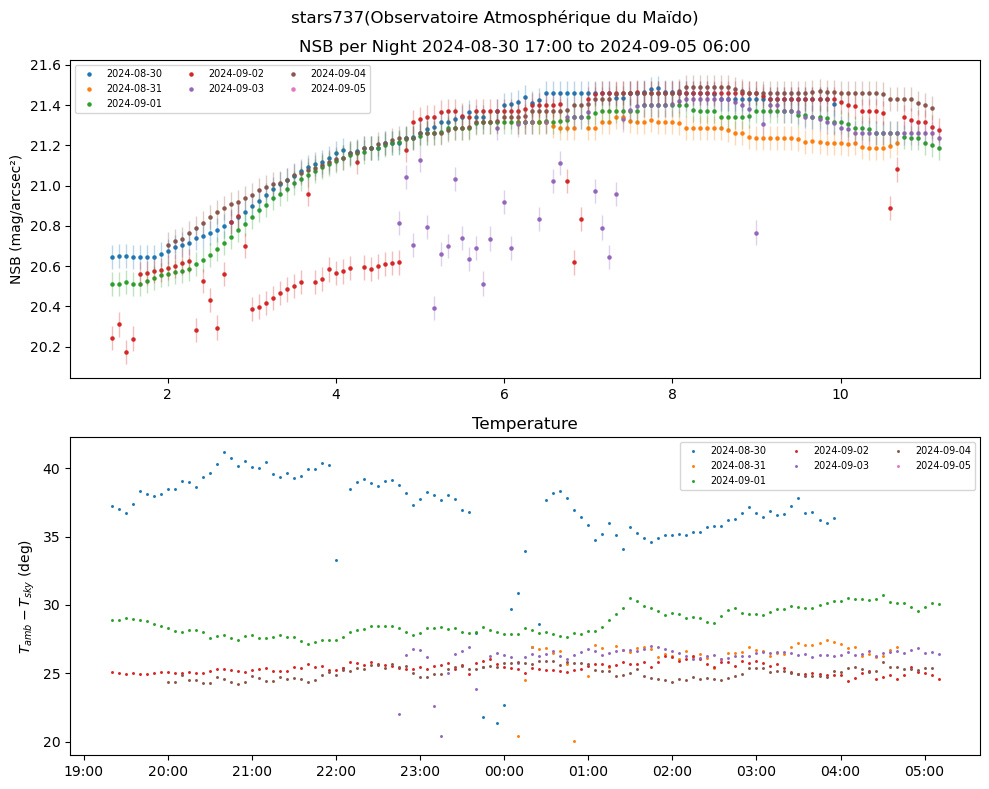

In [12]:
period['night'] = (period.index - pd.Timedelta(hours=6)).date #Creation d'une colonne night de 18h - 6h
period['night_time'] = ((period.index - pd.to_datetime(period['night'])) / pd.Timedelta(hours=1)) - 18 #Creation de la colonne nuit
#Visualisation de l'evolution du NSB par nuit dans un seul graph

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

for d, g in period.groupby('night'):
    axes[0].errorbar(g['night_time'], g['NSB'], yerr = 0.06, markersize=1 ,elinewidth=1, alpha=0.3, fmt='o')
    axes[0].scatter(g['night_time'], g['NSB'], marker='o', s=5, label=d)
    axes[1].scatter(g['night_time'], g['T_AMB']-g['T_SKY'], marker='.', s=5, label=d)
    
plt.suptitle('stars737(Observatoire Atmosphérique du Maïdo)')

axes[0].set_title(f"NSB per Night {start} to {end}")
#axes[0].set_xlabel("Hours 18:00 to 6")
axes[0].set_ylabel("NSB (mag/arcsec²)")
axes[0].legend(fontsize='x-small', ncol=3)

axes[1].set_title("Temperature")
axes[1].set_ylabel("$T_{amb} - T_{sky}$ (deg)")
axes[1].legend(fontsize='x-small', ncol=3)

# Format x-axis to show HH:MM
def format_hour(x, _):
    hour = int(x + 18) % 24  # shift back to real time
    minute = int((x % 1) * 60)
    return f"{hour:02d}:{minute:02d}"

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))  # tick every 2 hours
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_hour))

plt.tight_layout()
plt.show()

In [13]:
night_filtered = period

night_filtered['night'] = (night_filtered.index - pd.Timedelta(hours=6)).date #Creation d'une colonne night de 18h - 6h

mask_time_window = (
    (night_filtered.index.hour == 23) & (night_filtered.index.minute == 30) | # Condition pour 23:30
    (night_filtered.index.hour == 0)  & (night_filtered.index.minute == 0)  | # Condition pour 00:00
    (night_filtered.index.hour == 0)  & (night_filtered.index.minute == 30)   # Condition pour 00:30
)

nsb_midnight_window = night_filtered[mask_time_window].copy()

mean_nsb_at_midnight_window = nsb_midnight_window.groupby('night')['NSB'].mean()

# Renomme la série résultante pour plus de clarté
mean_nsb_at_midnight_window.name = 'mean_nsb_23h45_00h15_window'

# Convertie l'index 'night' de la Series résultante en DatetimeIndex pour faciliter le traçage
mean_nsb_at_midnight_window.index = pd.to_datetime(mean_nsb_at_midnight_window.index)

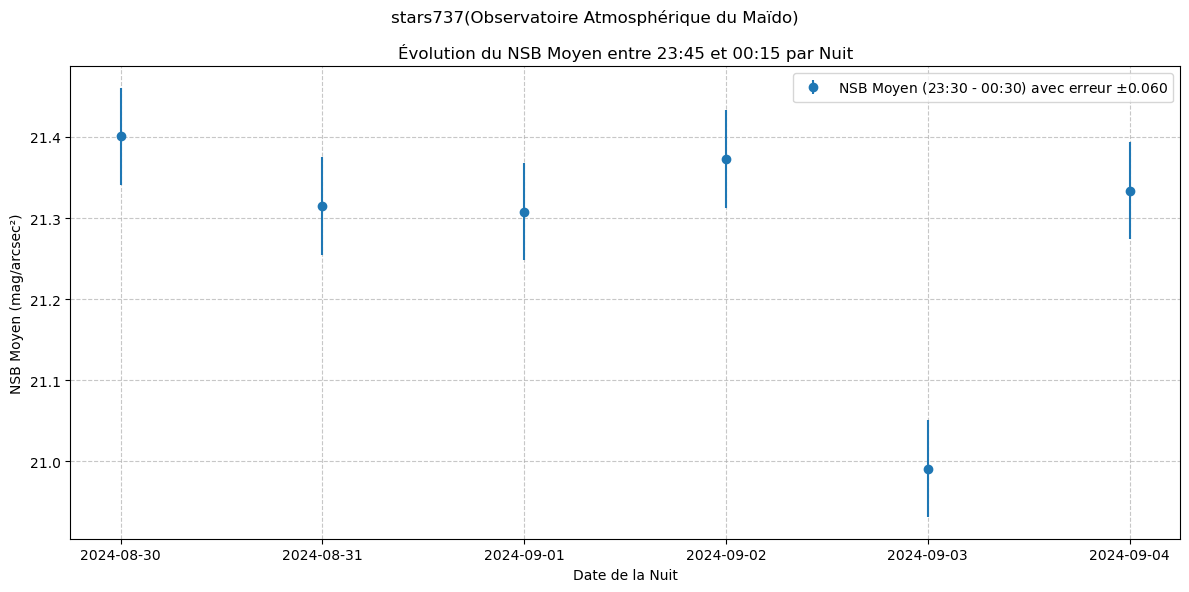

In [14]:
# Trace l'évolution de cette moyenne par nuit
photometer_error = 0.06 # mag/arcsec^2

plt.figure(figsize=(12, 6))

plt.errorbar(
    x=mean_nsb_at_midnight_window.index, 
    y=mean_nsb_at_midnight_window.values, 
    yerr=photometer_error,
    fmt='o',
    label=f'NSB Moyen (23:30 - 00:30) avec erreur $\\pm {photometer_error:.3f}$'
)

plt.suptitle('stars737(Observatoire Atmosphérique du Maïdo)')

plt.title('Évolution du NSB Moyen entre 23:45 et 00:15 par Nuit')
plt.xlabel('Date de la Nuit')
plt.ylabel('NSB Moyen (mag/arcsec²)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
night_m = night_5

night_m['mois'] = night_m.index.month
night_m['annee'] = night_m.index.year
night_m['annee_mois'] = night_m.index.to_period('M').astype(str)

In [16]:
df_monthly_stats = night_m.groupby('annee_mois')['NSB'].median().reset_index()

# Renommer la colonne résultante en 'Median_NSB' pour plus de clarté
df_monthly_stats = df_monthly_stats.rename(columns={'NSB': 'Median_NSB'})

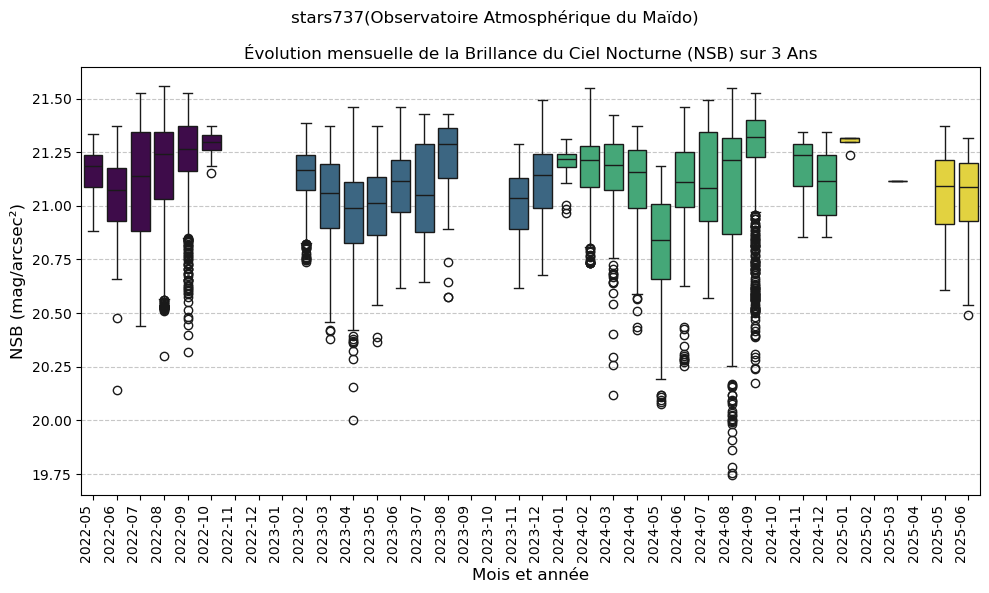

In [17]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='annee_mois', y='NSB', data=night_m, hue='annee', palette='viridis', legend=False)

plt.suptitle('stars737(Observatoire Atmosphérique du Maïdo)')

plt.title('Évolution mensuelle de la Brillance du Ciel Nocturne (NSB) sur 3 Ans')
plt.xlabel('Mois et année', fontsize=12)
plt.ylabel('NSB (mag/arcsec²)', fontsize=12)

plt.xticks(rotation=90, ha='right', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [18]:
df_sunspot_raw = pd.read_csv('../Sunspot.csv', sep=';')

In [19]:
df_sunspot_raw['Date'] = pd.to_datetime(df_sunspot_raw['Obsdate']) 
df_sunspot_raw.set_index('Date', inplace=True)
df_sunspot_raw['Sunspot_Number'] = pd.to_numeric(df_sunspot_raw['swpc_ssn'], errors='coerce') # <--- MODIFIEZ CECI !
df_sunspot_raw.dropna(subset=['Sunspot_Number'], inplace=True)

df_sunspot_monthly = df_sunspot_raw.resample('MS')['Sunspot_Number'].mean().reset_index()

if 'index' in df_sunspot_monthly.columns:
    df_sunspot_monthly.rename(columns={'index': 'Month_Year'}, inplace=True)
elif 'Date' in df_sunspot_monthly.columns: # Si votre index original était nommé 'Date'
    df_sunspot_monthly.rename(columns={'Date': 'Month_Year'}, inplace=True)

In [20]:
df_sunspot_monthly
df_sunspot_monthly.dropna(subset=['Sunspot_Number'], inplace=True)

In [21]:
min_date_nsb = night_m.index.min()
max_date_nsb = night_m.index.max()
    
df_sunspot_monthly['Month_Year'] = pd.to_datetime(df_sunspot_monthly['Month_Year'])

df_sunspot_monthly_filtered = df_sunspot_monthly[
    (df_sunspot_monthly['Month_Year'] >= min_date_nsb.to_period('M').start_time) &
    (df_sunspot_monthly['Month_Year'] <= max_date_nsb.to_period('M').end_time)
    ].copy() #
    
df_sunspot_to_plot = df_sunspot_monthly_filtered

In [22]:
df_sunspot_to_plot.set_index('Month_Year', inplace=True)

In [23]:
df_sunspot_to_plot['mois'] = df_sunspot_to_plot.index.month
df_sunspot_to_plot['annee'] = df_sunspot_to_plot.index.year
df_sunspot_to_plot['annee_mois'] = df_sunspot_to_plot.index.to_period('M').astype(str)

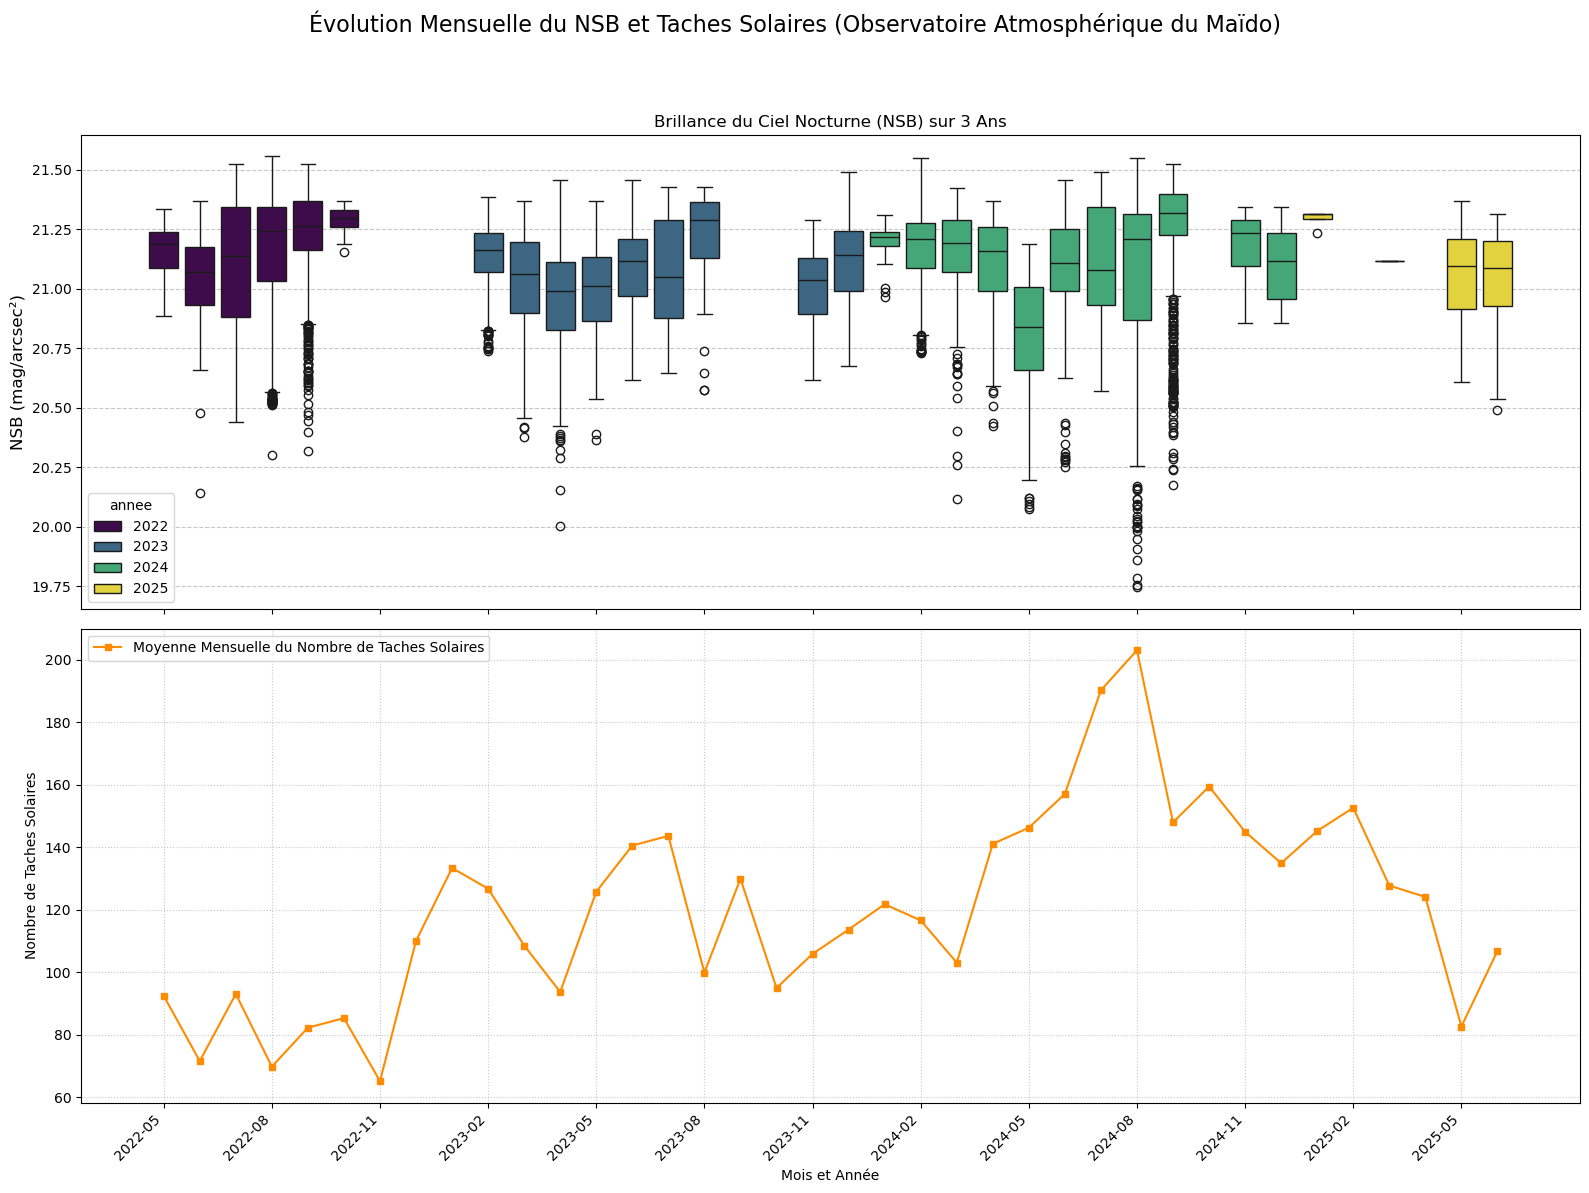

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

sns.boxplot(x='annee_mois', y='NSB', data=night_m, hue='annee', palette='viridis', ax=ax1)

ax1.set_title('') 
ax1.set_xlabel('') 
ax1.set_ylabel('NSB (mag/arcsec²)', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle('Évolution Mensuelle du NSB et Taches Solaires (Observatoire Atmosphérique du Maïdo)', fontsize=16, y=1.02)
ax1.set_title('Brillance du Ciel Nocturne (NSB) sur 3 Ans') 

unique_annee_mois = sorted(night_m['annee_mois'].unique())

tick_interval = 3
tick_positions = np.arange(0, len(unique_annee_mois), tick_interval)
tick_labels = [unique_annee_mois[i] for i in tick_positions]
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, rotation=45, ha='right')

ax2.plot(df_sunspot_to_plot['annee_mois'], df_sunspot_to_plot['Sunspot_Number'],
         color='darkorange', linestyle='-', marker='s', markersize=5,
         label='Moyenne Mensuelle du Nombre de Taches Solaires')

ax2.set_xlabel('Mois et Année')
ax2.set_ylabel('Nombre de Taches Solaires')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle=':', alpha=0.7)


plt.setp(ax1.get_xticklabels(), visible=False) 
fig.autofmt_xdate(rotation=45) 
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 

plt.show()